# JF image read
## Thomas Preston - European XFEL GmbH

In [1]:
%matplotlib notebook
import os
import numpy as np
import scipy
from scipy import optimize, ndimage

import matplotlib.pyplot as plt
from matplotlib import cm
from extra_data import *
from extra_data import by_id
import pandas as pd
import zipfile

## Prepare folder locations with experimental run and proposal number
## Change this cell!

In [2]:
# Create proposal directory
#propno = "3213" #"p002353" 
propno = "2838"
home_dir = "/home/jchal/"
prop_dir = home_dir+"p"+propno

os.chdir(home_dir)

# Make the output directory - caution, this makes the directory here where you run this script.
if not os.path.exists("p"+propno):
    os.mkdir("p"+propno)
    os.chdir(home_dir+"p"+propno)
else:
    os.chdir(home_dir+"p"+propno)

print(os.getcwd())

/home/jchal/p2838


### Open run and create run folder

In [3]:
#Open run and create run folder
run_number = 43
run_dir = prop_dir + "/"+"Run"+str(run_number)

run = open_run(propno, run_number, "proc")
#run.info()

os.chdir(prop_dir)

if not os.path.exists("Run"+str(run_number)):
    os.mkdir("Run"+str(run_number))
    os.chdir(run_dir)    
else:
    os.chdir(run_dir)
   
print("Current directory: " + os.getcwd())
print("Run " + str(run_number) + " contains " + str(len(run.train_ids)) + " train_IDs.")
print("Proceed to next cells to start data extraction ...")

Current directory: /home/jchal/p2838/Run43
Run 43 contains 11640 train_IDs.
Proceed to next cells to start data extraction ...


In [65]:
run.instrument_sources
#run.info()

frozenset({'HED_IA1_EPX100-1/DET/RECEIVER:daqOutput',
           'HED_IA1_EPX100-2/DET/RECEIVER:daqOutput',
           'HED_IA1_JF500K1/DET/JNGFR01:daqOutput',
           'HED_IA1_JF500K2/DET/JNGFR02:daqOutput',
           'HED_IA1_JF500K3/DET/JNGFR03:daqOutput',
           'HED_IA1_TSC-1/CAM/TARGET_FRONT:daqOutput',
           'HED_IA1_TSC-2/CAM/TARGET_BACK:daqOutput',
           'HED_OPT_IPM/ADC/1:channel_0.output',
           'HED_OPT_IPM/ADC/1:channel_1.output',
           'HED_OPT_IPM/ADC/1:channel_2.output',
           'HED_OPT_IPM/ADC/1:channel_3.output',
           'HED_OPT_IPM/ADC/1:channel_4.output',
           'HED_OPT_IPM/ADC/1:channel_5.output',
           'HED_OPT_IPM/ADC/1:channel_6.output',
           'HED_OPT_IPM/ADC/1:channel_7.output',
           'HED_OPT_IPM/ADC/1:channel_8.output',
           'HED_OPT_IPM/ADC/1:channel_9.output',
           'HED_RR_SYS/MDL/KARABACON:output',
           'HED_XTD6_XGM/XGM/DOOCS:output',
           'SA2_XTD1_XGM/XGM/DOOCS:output',
   

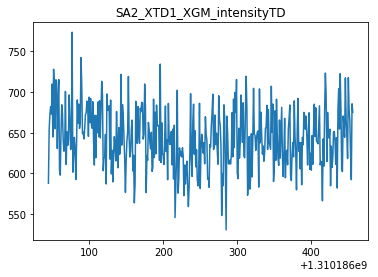

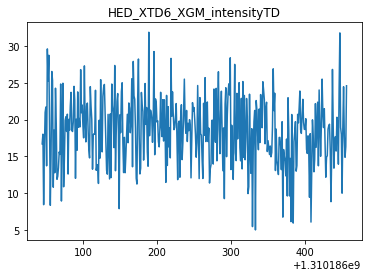

In [138]:
# Pulse energy data (XGM)
%matplotlib inline
SA2_XTD1_XGM_iTD = run['SA2_XTD1_XGM/XGM/DOOCS:output', 'data.intensityTD'].xarray().squeeze()
SA2_XTD1_XGM_tID = run['SA2_XTD1_XGM/XGM/DOOCS:output', 'data.trainId'].xarray().squeeze()

HED_XTD6_XGM_iTD = run['HED_XTD6_XGM/XGM/DOOCS:output', 'data.intensityTD'].xarray().squeeze()
HED_XTD6_XGM_tID = run['HED_XTD6_XGM/XGM/DOOCS:output', 'data.trainId'].xarray().squeeze()

SA2_XTD1_XGM = np.column_stack((SA2_XTD1_XGM_tID.data[:], SA2_XTD1_XGM_iTD.data[:,0]))
HED_XTD6_XGM = np.column_stack((HED_XTD6_XGM_tID.data[:], HED_XTD6_XGM_iTD.data[:,0]))

plt.plot(SA2_XTD1_XGM[:,0], SA2_XTD1_XGM[:,1])
plt.title("SA2_XTD1_XGM_intensityTD")
plt.show()

plt.plot(HED_XTD6_XGM[:,0], HED_XTD6_XGM[:,1])
plt.title("HED_XTD6_XGM_intensityTD")
plt.show()

# Save XGM data
os.chdir(prop_dir)
np.savetxt("Run" + str(run_number)+ "_SA2_XTD1_XGM.txt", SA2_XTD1_XGM, delimiter = ',', header = "SA2_XTD1_XGM_trainID, SA2_XTD1_XGM_intensityTD")
np.savetxt("Run" + str(run_number)+ "_HED_XTD6_XGM.txt", HED_XTD6_XGM, delimiter = ',', header = "HED_XTD6_XGM_trainID, HED_XTD6_XGM_intensityTD")

In [107]:
### Jungfrau data extraction and zipping

# JF3 = run['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'].xarray().squeeze().mean("trainId")
# this averages over all train IDs and squeezes out the extra nested array in JF images
#help(run)

os.chdir(run_dir)

#N_trains = len(run.train_ids)
N_trains = 200
start = 0
print("Extracting files ...")

for i in range(start, start+N_trains): 
    sel = run.select_trains(i)
    JF3 = sel['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'].xarray().squeeze()
    #print("Extracted train_ID " + str(run.train_ids[i]))
    
    # Export to unformated file
    f = open("T"+str(run.train_ids[i])+".dat", "w")
    JF3.data.tofile(f)
    f.close()
    
    #Export to TIF file
    #if JF3.data.max().__gt__(100000.0):
        #plt.imsave("T"+str(run.train_ids[i])+".tif",JF3.data, format="tif", cmap = cm.gray)
        #print(str(i) + "," + str(JF3.data.max()))   
    

# ZIP the data in the prop folder
os.chdir(prop_dir)
print("Saving ZIP file to: " +os.getcwd())
#print(os.listdir('.'))

zf = zipfile.ZipFile("Run"+str(run_number)+".zip", "w")
for file in os.listdir("Run"+str(run_number)):
    #print(file)
    #zf.write(os.path.join("Run"+str(run_number)+"/", file))
    zf.write(os.path.join("Run"+str(run_number), file))
    
zf.close()



Extracting files ...
Saving ZIP file to: /home/jchal/p2838


In [7]:
### Jungfrau data extraction and zipping
### only used trainIDs

# JF3 = run['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'].xarray().squeeze().mean("trainId")
# this averages over all train IDs and squeezes out the extra nested array in JF images
#help(run)
%matplotlib inline

os.chdir(run_dir)



start = 0
print("Extracting files ...")

#TraiIDs used
PPU = run['HED_XTD6_PPU/MDL/PPU_TRIGGER','trainTrigger.sequenceStart.value'].xarray().squeeze()
PPU = PPU +1
#print(PPU.data.shape)

sel = run['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'][by_id[PPU.data]]
#sel = run['HED_IA1_JF500K2/DET/JNGFR02:daqOutput', 'data.adc'][by_id[PPU.data]]
#sel = run['HED_IA1_EPX100-1/DET/RECEIVER:daqOutput', 'data.image.pixels'][by_id[PPU.data]]
#sel = run['HED_EXP_IBS/CAM/CAM:daqOutput', 'data.image.pixels'][by_id[PPU.data]]


print(len(sel.train_ids))
#N_trains = len(sel.train_ids)
N_trains = 10

#sel_trainIDs = run.train_ids[by_id[PPU.data]]
for i in range(start, start+N_trains): 
    #sel = run.select_trains(by_id[PPU.data[i]])
    JF3 = sel[i].xarray().squeeze()
    print("Extracted train_ID " + str(sel.train_ids[i]))
    
    ## Export to unformated file
    #f = open("T"+str(sel.train_ids[i])+".dat", "w")
    #JF3.data.tofile(f)
    #f.close()
    
    #Export to TIF file
    #if JF3.data.max().__gt__(100000.0):
        #plt.imsave("T"+str(run.train_ids[i])+".tif",JF3.data, format="tif", cmap = cm.gray)
        #print(str(i) + "," + str(JF3.data.max()))   

    plt.figure()
    JF3.data=np.where(JF3.data<0,0,JF3.data)
    plt.imshow(JF3.data,  vmin = 0, vmax = 200, cmap="jet")
    #plt.imshow(JF3.data, cmap="jet")
    #print(JF3.data.max())
    cbar = plt.colorbar()
    plt.title("Run:" + str(run_number)+ "; Train:" + str(run.train_ids[i]))
    plt.show()
    

## ZIP the data in the prop folder
#os.chdir(prop_dir)
#print("Saving ZIP file to: " +os.getcwd())
##print(os.listdir('.'))

#zf = zipfile.ZipFile("Run"+str(run_number)+".zip", "w")
#for file in os.listdir("Run"+str(run_number)):
#    #print(file)
#    #zf.write(os.path.join("Run"+str(run_number)+"/", file))
#    zf.write(os.path.join("Run"+str(run_number), file))   
#zf.close()


Extracting files ...


AttributeError: 'DataArray' object has no attribute 'train_ids'

(512, 1024)
124771.82


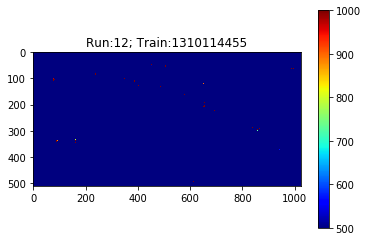

In [84]:
### Data viewing
%matplotlib inline

#N_trains = len(run.train_ids)
N_trains = 1
start = 101
array = np.zeros([512,1024])
print(array.shape)
for i in range(start, start+N_trains): 
    sel = run.select_trains(i)
    JF3 = sel['HED_IA1_JF500K3/DET/JNGFR03:daqOutput', 'data.adc'].xarray().squeeze()
    #print("Extracted train_ID" + str(run.train_ids[i]))   
    plt.figure()
    JF3.data=np.where(JF3.data<0,0,JF3.data)
    plt.imshow(JF3.data,  vmin = 500, vmax = 1000, cmap="jet")
    #plt.imshow(JF3.data)
    print(JF3.data.max())
    #plt.imshow(np.log10(JF3.data), cmap="jet")
    cbar = plt.colorbar()
    #plt.clim(JF3.data.min(), JF3.data.max())
    #cbar.ax.set_ylabel("Intensity", rotation=270)
    #plt.ylim(390, 430)
    plt.title("Run:" + str(run_number)+ "; Train:" + str(run.train_ids[i]))
    plt.show()


# Export to CSV
#frame = pd.DataFrame(JF3.data)
#frame.to_csv("p"+propno+"/JF3.csv", float_format = "%.0f")

# Export to unformated file
#f = open("p"+propno+"/JF3.dat", "w")
#JF3.data.tofile(f)
#f.close()

In [97]:
# Delete all files in the run directory!!!
run_number = 35
run_dir = prop_dir + "/"+"Run"+str(run_number)
os.chdir(run_dir)
print("Deleting files in: " + os.getcwd())
for file in os.listdir("."):    
    if os.path.isfile(file):
        os.remove(file)
        #print("Delete: " + file)

Deleting files in: /home/jchal/p2838/Run35


In [14]:
#print(type(np.log10(JF3)))
# import cv2
# cv2.imwrite("p"+propno+"/JF3.csv",np.array([1,23,3]))
print(JF3.data.shape)
plt.imsave("p"+propno+"/JF3.tif",JF3.data, format="tif", cmap = cm.gray) 
#plt.imshow(np.log10(JF3.data))

(512, 1024)


In [8]:
jf=run['HED_IA1_JF500K3/DET/CONTROL']
dir(jf)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_glob_keys',
 '_has_exact_key',
 '_index_group_names',
 '_is_control',
 '_only_tids',
 'files',
 'inc_suspect_trains',
 'keys',
 'section',
 'sel_keys',
 'select_keys',
 'select_trains',
 'source',
 'train_ids',
 'union']